# Discretization of the Plane for Rectangular Obstacles
This document will solve a discretization problem where the obstacles are rectangles. To do this, we will construct a quantum circuit that checks if a point belongs to a set of rectangles. Once this circuit is constructed, we can use Grover's algorithm to solve our problem.


The `Pennylane` library is not loaded by default in Google Colab. Therefore, its installation might be required to run the code.

In [ ]:
!pip install pennylane > out



We load the libraries that will enable us to solve the problem

In [ ]:
## Libraries
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
import time
%config InlineBackend.figure_format = 'retina'


The following two functions allow us to draw our problem.

In [ ]:
# Function to draw a grid
def draw_board():
    # Define the limits for the grid
    x_lim = [-1, 2**nCoordX]
    y_lim = [-1, 2**nCoordY]

    # Set the limits for the plot
    plt.xlim(x_lim[0], x_lim[1])
    plt.ylim(y_lim[0], y_lim[1])

    # Set labels for the axes
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    # Determine the number of rows based on y-coordinate
    nRows = 2**nCoordY

    # Draw horizontal and vertical lines to create the grid
    for i in range(nRows):
        plt.plot([0, 2**nCoordX - 1], [i, i], color="black", linewidth=0.3)
        plt.plot([i, i], [0, 2**nCoordY - 1], color="black", linewidth=0.3)
    return

# Function to draw points on the grid
def draw_points(list_points):
    # Get the number of points to draw
    nPoints = len(list_points)

    # Draw each point in red
    for i in range(nPoints):
        plt.scatter(list_points[i][0], list_points[i][1], color="red")

# Uncomment the following line to draw the board
# draw_board()


The following class helps us solving the problem.
This code defines a class **pcRectangle** to represent a rectangle. It initializes four corners of the rectangle and provides methods for initializing it using two corner points, calculating its area, adding it to a plot with a specified color, and generating a string representation of its coordinates. The class is then used with specific values for X and Y coordinates.




In [ ]:
# Class to represent a rectangle
class pcRectangle:
    def __init__(self):
        # Initialize the four corners of the rectangle with zero coordinates
        self.m_p2dCorner00 = np.array((0.0, 0.0))  # Lower left corner
        self.m_p2dCorner01 = np.array((0.0, 0.0))  # Upper left corner
        self.m_p2dCorner10 = np.array((0.0, 0.0))  # Lower right corner
        self.m_p2dCorner11 = np.array((0.0, 0.0))  # Upper right corner

    # Initialize the rectangle with two opposite corners
    def InitializeBy2Pnts(self, pntCornerA, pntCornerB):
        # Lower left corner
        self.m_p2dCorner00[0] = np.min((pntCornerA[0], pntCornerB[0]))
        self.m_p2dCorner00[1] = np.min((pntCornerA[1], pntCornerB[1]))
        # Upper right corner
        self.m_p2dCorner11[0] = np.max((pntCornerA[0], pntCornerB[0]))
        self.m_p2dCorner11[1] = np.max((pntCornerA[1], pntCornerB[1]))
        # Lower right corner
        self.m_p2dCorner10[0] = self.m_p2dCorner11[0]
        self.m_p2dCorner10[1] = self.m_p2dCorner00[1]
        # Upper left corner
        self.m_p2dCorner01[0] = self.m_p2dCorner00[0]
        self.m_p2dCorner01[1] = self.m_p2dCorner11[1]

    # Calculate the area of the rectangle
    def Area(self):
        return (self.m_p2dCorner11[0] - self.m_p2dCorner00[0]) * (self.m_p2dCorner11[1] - self.m_p2dCorner00[1])

    # Add the rectangle to the plot with a specified color
    def AddFillRectangleToPlot(self, strColor='black'):
        vX = [self.m_p2dCorner00[0], self.m_p2dCorner10[0]]
        vY1 = [self.m_p2dCorner00[1], self.m_p2dCorner10[1]]
        vY2 = [self.m_p2dCorner01[1], self.m_p2dCorner11[1]]
        plt.fill_between(vX, vY1, vY2, color=strColor, alpha=0.6)
        return

    # String representation of the rectangle
    def __str__(self):
        return f"CoordX = ({self.m_p2dCorner00[0]},{self.m_p2dCorner10[0]}), CoordY = ({self.m_p2dCorner00[1]}, {self.m_p2dCorner11[1]})"

# Set the number of coordinates for X and Y
nCoordX = 5
nCoordY = 5


### 2 Quantum circuits
The following functions implement quantum circuits that allow us to perform the arithmetic operations necessary to solve our problem.

In [ ]:
# Function to convert a binary array to its corresponding integer value
def binary_to_integer(vOutput):
    # Create an array of powers of 2, corresponding to each binary digit's position
    vPows = 2**np.array(range(len(vOutput)))
    # Reverse the array to match the binary representation (MSB to LSB)
    vPows = vPows[::-1]
    # Calculate the integer by taking the dot product of the binary array and the powers of 2
    return np.dot(vOutput, vPows)

# Function to apply Hadamard gates to a set of qubits
def apply_hadamard(wires_h):
    # Iterate over the list of qubits (wires) and apply the Hadamard gate to each
    for i in wires_h:
        qml.Hadamard(wires=i)


In [ ]:
# Implement arithmetic operations to build the oracle
def sum_k(k, wires):
    # Apply phase rotations for each qubit in wires
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

def check_interval_1(wires_a, wires_aux, interval):
    # Check if enough ancillary qubits are available for interval checking
    if len(wires_aux) < 3:
        print("Not enough ancillary qubits to check the interval")
        return

    # Prepare the qubits for the first check
    wires_current_a = [wires_aux[0]] + wires_a
    # First check: whether the value is above the lower bound of the interval
    qml.QFT(wires_current_a)
    sum_k(-interval[0], wires_current_a)
    qml.adjoint(qml.QFT)(wires_current_a)
    qml.PauliX(wires=wires_current_a[0])
    qml.CNOT(wires=[wires_current_a[0], wires_aux[1]])
    qml.PauliX(wires=wires_current_a[0])

    # Second check: whether the value is below the upper bound of the interval
    qml.QFT(wires_current_a)
    sum_k(+interval[0] - (interval[1]+1), wires_current_a)
    qml.adjoint(qml.QFT)(wires_current_a)
    qml.CNOT(wires=[wires_current_a[0], wires_aux[2]])

def check_interval(wires_a, wires_aux, wires_res, interval):
    # Combine the first and second checks to determine if within the interval
    check_interval_1(wires_a, wires_aux, interval)
    qml.Toffoli(wires=[wires_aux[1], wires_aux[2], wires_res[0]])
    qml.adjoint(check_interval_1)(wires_a, wires_aux, interval)


In [ ]:
# Function to check if a point belongs to a rectangle
def check_rectangle(wires_x, wires_y, wires_aux, wires_res, rectangle):
    """
    Checks if a point lies within a specified rectangle.

    Pre-conditions:
    - wires_x: Qubit wires representing the x-coordinate of the point.
    - wires_y: Qubit wires representing the y-coordinate of the point.
    - wires_aux: Ancillary qubits for intermediate calculations.
    - wires_res: Qubit wire for storing the final result.
    - rectangle: A pcRectangle object defining the rectangle.
    - Requires at least 5 ancillary qubits.

    Post-conditions:
    - The result qubit (wires_res[0]) is set to 1 if the point is within the rectangle, 0 otherwise.
    - The ancillary qubits are returned to their initial state.
    """

    # Ensure enough ancillary qubits are available for rectangle checking
    if len(wires_aux) < 5:
        print("The number of ancillary qubits to check if is in rectangle must be more than 5")
        return

    # Define intervals for x and y coordinates based on rectangle corners
    interval1 = np.array((rectangle.m_p2dCorner00[0], rectangle.m_p2dCorner11[0]))
    interval2 = np.array((rectangle.m_p2dCorner00[1], rectangle.m_p2dCorner11[1]))

    # Check if x-coordinate falls within the x-interval of the rectangle
    check_interval(wires_x, wires_aux[:3], [wires_aux[3]], interval1)

    # Check if y-coordinate falls within the y-interval of the rectangle
    check_interval(wires_y, wires_aux[:3], [wires_aux[4]], interval2)

    # Use Toffoli gate to determine if the point lies within both intervals
    qml.Toffoli(wires=[wires_aux[3], wires_aux[4], wires_res[0]])

    # Reverse the interval checks to reset ancillary qubits
    qml.adjoint(check_interval)(wires_x, wires_aux[:3], [wires_aux[3]], interval1)
    qml.adjoint(check_interval)(wires_y, wires_aux[:3], [wires_aux[4]], interval2)


We are going to build a quantum circuit to verify that the functions we have just implemented work correctly.

In [ ]:
# Function to create the quantum circuit
wires_x = list(range(5))
wires_y = list(range(5, 10))
wires_aux = list(range(10, 15))
wires_res = [15]

# Quantum device setup
dev = qml.device("default.qubit", wires=16, shots=1)

# Quantum circuit definition
@qml.qnode(dev)
def circuit(x_value, y_value, rectangle):
    """
    Quantum circuit to check if a point is inside a given rectangle.

    Pre-conditions:
    - x_value: Binary representation of the x-coordinate of the point.
    - y_value: Binary representation of the y-coordinate of the point.
    - rectangle: A pcRectangle object defining the rectangle.

    Post-conditions:
    - Returns the sample of the quantum state after executing the circuit.
    - The circuit encodes the x and y coordinates, checks if the point is inside the rectangle,
      and records the result in wires_res.
    """

    # Embed x and y values into the circuit
    qml.BasisEmbedding(x_value, wires=wires_x)
    qml.BasisEmbedding(y_value, wires=wires_y)

    # Check if the point is within the given rectangle
    check_rectangle(wires_x, wires_y, wires_aux, wires_res, rectangle)

    # Sample and return the final state of the circuit
    return qml.sample()

# Define an example obstacle
corner00 = np.array((5, 10))
corner11 = np.array((8, 12))
recRandomRectangle = pcRectangle()
recRandomRectangle.InitializeBy2Pnts(corner00, corner11)

# Check the solution for an example point
sol = circuit(6, 12, recRandomRectangle)
print("The number is (", sol[wires_x], ",", sol[wires_y], ")")
print("The value of the wires aux is", sol[wires_aux])
print("The solucion is ", sol[wires_res])


The number is ( [0 0 1 1 0] , [0 1 1 0 0] )
The value of the wires aux is [0 0 0 0 0]
The solucion is  [1]


Once we have built a function that checks whether a point belongs to a rectangle, we can generalize it to the case in which there are several rectangles.

This function extends the `check_rectangle` function to handle multiple rectangles. It loops through a list of rectangle objects, checking each one and updating the quantum state accordingly. The function ensures that there are enough auxiliary qubits for the computation and applies a `Quantum Fourier Transform` to accumulate the results of the checks.

In [ ]:
# Function to check inclusion in multiple rectangles
def check_multirectangles(wires_x, wires_y, wires_aux, wires_sum, list_rectangle):
    """
    Quantum circuit to check if a point is inside any of the given rectangles.

    Pre-conditions:
    - wires_x: Qubits representing the x-coordinate of the point.
    - wires_y: Qubits representing the y-coordinate of the point.
    - wires_aux: Auxiliary qubits for intermediate calculations.
    - wires_sum: Qubits to record the sum of the inclusion checks.
    - list_rectangle: List of pcRectangle objects defining multiple rectangles.

    Post-conditions:
    - Modifies the state of wires_sum based on the number of rectangles the point belongs to.
    - Requires a minimum of 6 auxiliary qubits.
    """

    # Ensure enough ancillary qubits are available
    if len(wires_aux) < 6:
        print("The number of ancillary qubits must be more than 6")
        return

    # Setup for checking a single rectangle
    wires_res_one_rectangle = [wires_aux[0]]
    wires_aux_one_rectangle = wires_aux[1:]

    # Apply Quantum Fourier Transform on the sum qubits
    qml.QFT(wires=wires_sum)

    # Loop through each rectangle and perform the check
    for rectangle in list_rectangle:
        # Check if the point is in the current rectangle
        check_rectangle(wires_x, wires_y, wires_aux_one_rectangle, wires_res_one_rectangle, rectangle)

        # Conditional sum based on the check result
        qml.ctrl(sum_k, control=wires_res_one_rectangle[0])(1, wires_sum)

        # Reset the circuit to its state before the rectangle check
        qml.adjoint(check_rectangle)(wires_x, wires_y, wires_aux_one_rectangle, wires_res_one_rectangle, rectangle)

    # Apply the inverse Quantum Fourier Transform on the sum qubits
    qml.adjoint(qml.QFT)(wires=wires_sum)


We create several rectangles that will act as obstacles.

The total area covered by obstacles is 727.0
Proportion of area covered by obstacles: 0.7099609375


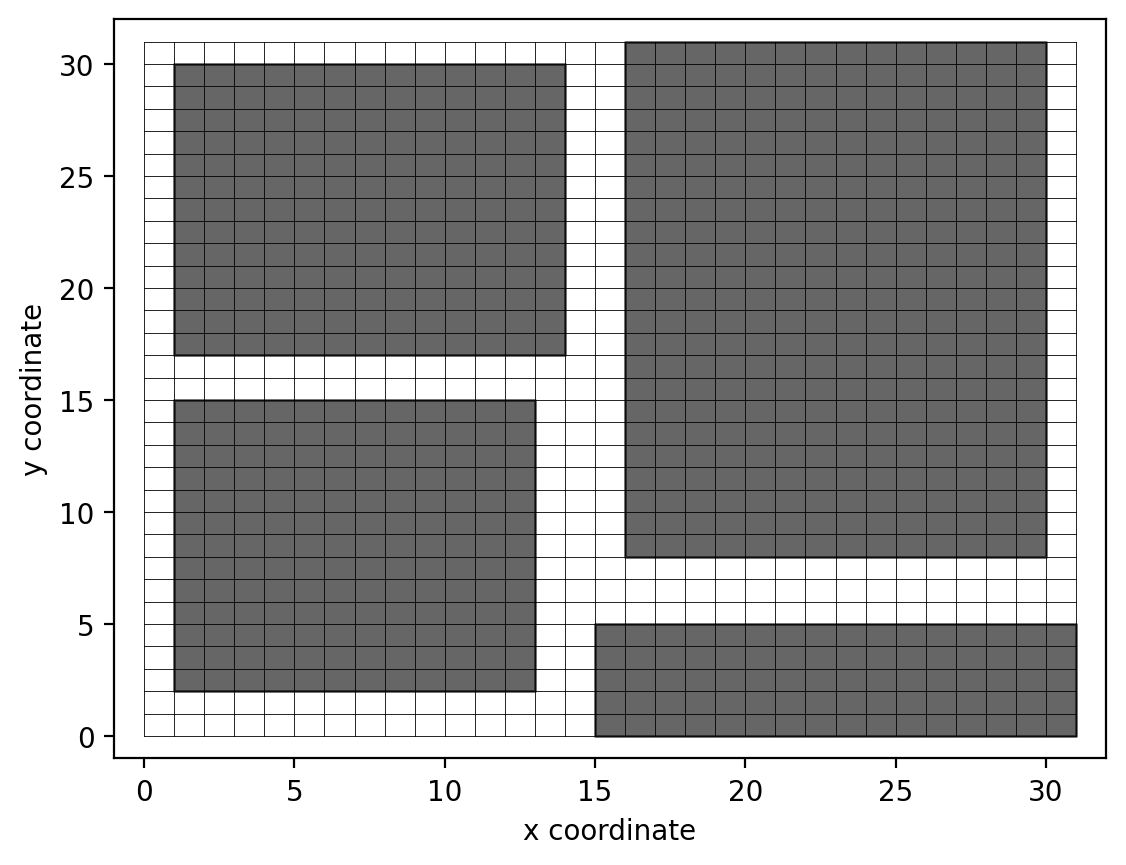

In [ ]:
## Setting up the obstacles
list_rectangle = []

# Pre-condition: pcRectangle class and drawing functions must be defined

## Obstacle 1
corner00 = np.array((1, 2))
corner11 = np.array((13, 15))
recRandomRectangle = pcRectangle()
recRandomRectangle.InitializeBy2Pnts(corner00, corner11)
list_rectangle.append(recRandomRectangle)

## Obstacle 2
corner00 = np.array((1, 17))
corner11 = np.array((14, 30))
recRandomRectangle = pcRectangle()
recRandomRectangle.InitializeBy2Pnts(corner00, corner11)
list_rectangle.append(recRandomRectangle)

## Obstacle 3
corner00 = np.array((16, 8))
corner11 = np.array((30, 31))
recRandomRectangle = pcRectangle()
recRandomRectangle.InitializeBy2Pnts(corner00, corner11)
list_rectangle.append(recRandomRectangle)

## Obstacle 4
corner00 = np.array((15, 0))
corner11 = np.array((31, 5))
recRandomRectangle = pcRectangle()
recRandomRectangle.InitializeBy2Pnts(corner00, corner11)
list_rectangle.append(recRandomRectangle)

# Post-condition: Rectangles are defined and stored in list_rectangle

## Drawing the rectangles and calculating the total area
area_total = 0
for rectangle in list_rectangle:
    rectangle.AddFillRectangleToPlot()
    area_total += rectangle.Area()
draw_board()
print("The total area covered by obstacles is", area_total)
print("Proportion of area covered by obstacles:", area_total / (32 * 32))


The following circuit checks if a point belongs to several rectangles.

In [ ]:
## Circuit to Check Multiple Rectangles
# Pre-condition: Required functions and classes must be defined

# Setting up the circuit
wires_x = list(range(5))
wires_y = list(range(5, 10))
wires_aux = list(range(10, 16))
wires_sum = list(range(16, 19))
nTotalWires = len(wires_x) + len(wires_y) + len(wires_aux) + len(wires_sum)

dev = qml.device("default.qubit", wires = nTotalWires, shots = 1)

@qml.qnode(dev)
def circuit(wires_x, wires_y, wires_aux, wires_sum, list_rectangle):
    qml.BasisEmbedding(10, wires=wires_x)
    qml.BasisEmbedding(16, wires=wires_y)
    check_multirectangles(wires_x, wires_y, wires_aux, wires_sum, list_rectangle)
    return qml.sample()

# Testing the Circuit
sol = circuit(wires_x, wires_y, wires_aux, wires_sum, list_rectangle)
punto_sol = np.array((binary_to_integer(sol[wires_x]), binary_to_integer(sol[wires_y])))
print("The coordinates are (", punto_sol[0], ",", punto_sol[1], ")")
print("Belongs to ", binary_to_integer(sol[wires_sum]), "rectangles")

# Post-condition: Circuit outputs if the point belongs to any of the defined rectangles


The coordinates are ( 10 , 16 )
Belongs to  0 rectangles


### 3 Grover's algorithm
Once we have built all the previous functions we can build Grover's algorithm that will allow us to find points on the grid optimally.

This code defines two critical components of Grover's algorithm: the oracle and the diffuser. The oracle checks if a point belongs to any defined rectangles and flips the phase if it does. The diffuser operator then spreads the amplitude uniformly across all states, preparing the system for the next iteration of Grover's algorithm. The pre-and post-conditions clarify the requirements and outcomes of these functions.

In [ ]:
## Oracle for Multiple Rectangles
# Pre-condition: Functions for checking multiple rectangles and auxiliary operations must be defined

def Oracle(wires_x, wires_y, wires_aux, wires_sum, wires_res, list_rectangle):
    # Initialize the result wire
    qml.PauliX(wires = wires_res[0])
    qml.Hadamard(wires = wires_res[0])

    # Apply the check for multiple rectangles
    check_multirectangles(wires_x, wires_y, wires_aux, wires_sum, list_rectangle)
    vStringCombo = ''.join(str(0) for j in range(len(wires_sum)))
    qml.MultiControlledX(control_wires = wires_sum, wires = wires_res[0], control_values = vStringCombo)
    qml.adjoint(check_multirectangles)(wires_x, wires_y, wires_aux, wires_sum, list_rectangle)

    # Reset the result wire
    qml.Hadamard(wires = wires_res[0])
    qml.PauliX(wires = wires_res[0])

# Diffuser Operator
# Pre-condition: 'apply_hadamard' function must be defined

def DiffuserOperator(wires_x, wires_y, wires_aux):
    # Initialize the auxiliary qubit
    qml.PauliX(wires = wires_aux[0])
    qml.Hadamard(wires = wires_aux[0])

    # Apply the diffuser phase
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)
    wires_join = wires_x + wires_y
    vStringCombo = ''.join(str(0) for j in range(len(wires_join)))
    qml.MultiControlledX(control_wires = wires_join, wires = wires_aux[0], control_values = vStringCombo)
    qml.QubitUnitary(-np.eye(2), wires = 0)
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)

    # Reset the auxiliary qubit
    qml.Hadamard(wires = wires_aux[0])
    qml.PauliX(wires = wires_aux[0])

# Post-condition: The oracle and diffuser are set up to be used in Grover's algorithm for the quantum circuit


In [ ]:
## Quantum Circuit Creation
# Pre-condition: Required libraries and functions (like apply_hadamard, Oracle, DiffuserOperator) must be defined

nBitsPoint = 5
wires_x = list(range(5))
wires_y = list(range(5, 10))
wires_aux = list(range(10, 16))
wires_sum = list(range(16, 18))
wires_res = [18]
nTotalWires = len(wires_x) + len(wires_y) + len(wires_aux) + len(wires_sum) + len(wires_res)

# Choose the quantum device for simulation
dev = qml.device('default.qubit.tf', wires = nTotalWires, shots = 1)

@qml.qnode(dev)
def circuit(wires_x, wires_y, wires_aux, wires_sum, wires_res, list_rectangle):
    apply_hadamard(wires_x)
    apply_hadamard(wires_y)

    # Apply the Oracle and the Diffuser
    Oracle(wires_x, wires_y, wires_aux, wires_sum, wires_res, list_rectangle)
    DiffuserOperator(wires_x, wires_y, wires_aux)
    return qml.sample()

# Running the circuit and measuring execution time
start_time = time.time()
sol = circuit(wires_x, wires_y, wires_aux, wires_sum, wires_res, list_rectangle)
sol = sol.numpy()
point_solution = np.array((binary_to_integer(sol[wires_x]), binary_to_integer(sol[wires_y])))
print("The point is (", point_solution[0], ",", point_solution[1],")")
print("The value of auxiliary wires is", sol[wires_aux])

# Calculating total execution time
end_time = time.time()
total_time = end_time - start_time
print("Total execution time:", total_time, "seconds")

# Post-condition: The circuit applies Grover's algorithm and returns the sample of the quantum state, along with execution time


/usr/local/lib/python3.10/dist-packages/pennylane/ops/qubit/non_parametric_ops.py:2095: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


The point is ( 14 , 8 )
The value of auxiliary wires is [0 0 0 0 0 0]
Total execution time: 22.778987169265747 seconds


We prove on a circuit that the discretization algorithm works correctly.

The point is ( 0 , 21 )
The point is ( 15 , 31 )
The point is ( 15 , 13 )
The point is ( 7 , 1 )
The point is ( 31 , 19 )
The point is ( 15 , 8 )
The point is ( 31 , 6 )
The point is ( 14 , 8 )
The point is ( 25 , 7 )
The point is ( 8 , 1 )
Total execution time: 140.59933876991272 seconds


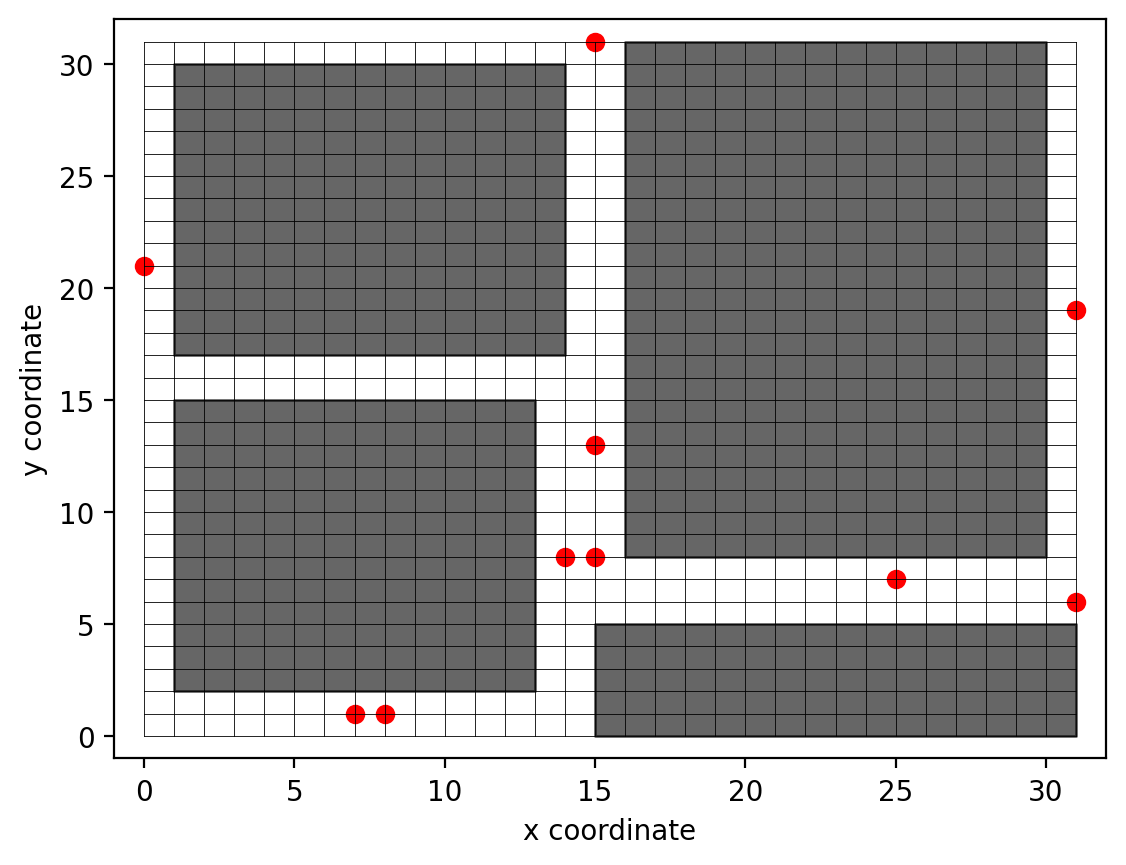

In [ ]:
# Pre-condition: Required libraries, functions, and quantum circuit (defined in previous steps) must be initialized

nPoints = 10
list_points = list()
start_time = time.time()

# Running the quantum circuit for each point
for i in range(nPoints):
    sol = circuit(wires_x, wires_y, wires_aux, wires_sum, wires_res, list_rectangle)
    sol = sol.numpy()
    point_solution = np.array((binary_to_integer(sol[wires_x]), binary_to_integer(sol[wires_y])))
    print("The point is (", point_solution[0], ",", point_solution[1],")")
    list_points.append(point_solution)

# Calculating total execution time
end_time = time.time()
total_time = end_time - start_time
print("Total execution time:", total_time, "seconds")

# Drawing the results
for rectangle in list_rectangle:
    rectangle.AddFillRectangleToPlot()
draw_board()
draw_points(list_points)

# Post-condition: The script runs the quantum circuit multiple times to generate points, measures the total execution time, and visualizes the results on a plot.


Cite this work as:
